# Regime Discovery in aFRR Prices

This notebook uses concepts of unsupervised learning using k-means and Agglomerative clustering to select a number of clusters on the dataset that incorporates aFRR balancing market components and certain exogenous datasets that may be influencing the prices. The clusters are selected based on relevant evaluation metrics and are further visualized on heatmaps, PCA and t-SNE plots. Finally the clusters are interpreted for regimes and both clustering methods are compared to review the feature regimes.

# Data loading, Preprocessing, and Feature Engineering

This cell imports the necessary libraries for data manipulation, analysis, visualization, and clustering.

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

sns.set(style='whitegrid', context='talk')


The following code defines a function `read_reserve` to read reserve market data from CSV files for the years 2023 and 2024, concatenate them, and set the timestamp as the index. It then reads the negative and positive reserve data using this function, selects specific price columns, renames them, and finally joins the two dataframes.

In [ ]:

def read_reserve(prefix):
    dfs = []
    for year in ['2023', '2024']:
        df = pd.read_csv(f'inputs/{prefix}_{year}.csv', index_col=0, parse_dates=True)
        df = df.drop(columns=['TYPE_OF_RESERVES', 'PRODUCT'])
        dfs.append(df)
    df = pd.concat(dfs).sort_index()
    df.index = df.index.tz_localize('Europe/Berlin', ambiguous='infer', nonexistent='shift_forward')
    return df

target_cols = [
    'GERMANY_MIN_CAPACITY_PRICE_[(EUR/MW)/h]',
    'GERMANY_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h]',
    'GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]'
]

afrr_neg = read_reserve('reserve_neg')[target_cols].rename(
    columns=dict(zip(target_cols, ['neg_min','neg_avg','neg_marginal']))
)
afrr_pos = read_reserve('reserve_pos')[target_cols].rename(
    columns=dict(zip(target_cols, ['pos_min','pos_avg','pos_marginal']))
)
afrr_df = afrr_neg.join(afrr_pos)


This cell defines two functions: `read_smard_csv` to read data from CSV files specifically from SMARD.DE, parse timestamps, set the index, and drop initial time columns; and `read_load_csv` to read load data (from ENTSO-E), parse timestamps, set the index, drop the initial time column, rename columns, and resample to hourly frequency from 15-minute interval using mean aggregation and calculate load change. It then uses these functions to read day-ahead prices, generation data, and VRE forecast data. It also reads load data for 2023 and 2024 and concatenates them.

Here, in the exogenous data, certain features are created beforehand to reduce further processing. The features created are:


*   `Total Generation` : sum of all generation types
*   `Generation Ramp` : hourly change in generation
*   `Load Change` : change in actual load
*   `Net Balance` : Generation - Load
*   `Total Generation Lag` : Previous day's Generation values

Finally, it concatenates all the exogenous values, resamples to 4-hour frequency with mean aggregation to match with the aFRR dataset, and joins with the aFRR dataframe.

In [ ]:

def read_smard_csv(file_path):
    df = pd.read_csv(f'inputs/{file_path}', sep=';', na_values=["-"], thousands=",")
    df['timestamp'] = pd.to_datetime(df['Start date'], format="%b %d, %Y %I:%M %p")
    df['timestamp'] = df['timestamp'].dt.tz_localize('Europe/Berlin', ambiguous='infer', nonexistent='shift_forward')
    df = df.set_index('timestamp').sort_index()
    df = df.drop(df.columns[:2], axis=1)
    return df

dap = read_smard_csv('day_ahead_prices_2023_24.csv')
gen = read_smard_csv('per_type_generation_2023_24.csv')
gen['Total Generation'] = gen.sum(axis=1)
gen['Generation Ramp'] = gen['Total Generation'].diff()
vre = read_smard_csv('vre_forecasted_2023_24.csv')

def read_load_csv(file_path):
    df = pd.read_csv(f'inputs/{file_path}')
    df['timestamp'] = pd.to_datetime(df.iloc[:,0].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
    df['timestamp'] = df['timestamp'].dt.tz_localize('Europe/Berlin', ambiguous='infer', nonexistent='shift_forward')
    df = df.set_index('timestamp')
    df = df.drop(columns=df.columns[0])
    df.columns = ['Load Forecast', 'Load Actual']
    return df

load_2023 = read_load_csv('load_2023.csv')
load_2024 = read_load_csv('load_2024.csv')
load = pd.concat([load_2023, load_2024]).sort_index()
load['Load Change'] = load['Load Actual'].diff()
load = load.resample('h').mean()

exog_df = pd.concat([
    dap[["Germany/Luxembourg [€/MWh] Original resolutions"]].rename(
        columns={"Germany/Luxembourg [€/MWh] Original resolutions":"DA_Price_DE_LU"}),
    gen[["Total Generation","Generation Ramp"]],
    gen[["Hydropower [MWh] Calculated resolutions","Hydro pumped storage [MWh] Calculated resolutions"]].rename(
        columns={"Hydropower [MWh] Calculated resolutions":"Hydro",
                 "Hydro pumped storage [MWh] Calculated resolutions":"Hydro Pumped Storage"}),
    vre[["Photovoltaics and wind [MWh] Calculated resolutions"]].rename(
        columns={"Photovoltaics and wind [MWh] Calculated resolutions":"VRE Forecasted"}),
    load[["Load Forecast","Load Actual","Load Change"]]
    ], axis=1)
exog_df['Net Balance'] = exog_df['Total Generation'] - exog_df['Load Actual']
exog_df = exog_df.resample('4h').mean()
exog_df['Total Generation lag'] = exog_df['Total Generation'].shift(6)
df = exog_df.join(afrr_df, how='outer')


This code defines a function `engineer_price_features` that takes the aFRR data as input and engineers new features based on the price column, such as volatility, rolling mean, ramp rate, spike indicator, and spike frequency. It then applies this function to the 'neg_avg' and 'pos_avg' columns in the dataframe.

In [ ]:

def engineer_price_features(df, price_col):
    df[f'{price_col}_volatility'] = df[price_col].rolling(window=6, min_periods=1).std()
    df[f'{price_col}_rolling_mean'] = df[price_col].rolling(window=6, min_periods=1).mean()
    df[f'{price_col}_spike'] = (df[price_col] > df[price_col].quantile(0.95)).astype(int)
    df[f'{price_col}_spike_freq'] = df[f'{price_col}_spike'].rolling(window=6, min_periods=1).sum()
    return df

df = engineer_price_features(df, 'neg_avg')
df = engineer_price_features(df, 'pos_avg')

This cell defines a function `select_compact_features` that takes a dataframe and the price column as input, selects a set of potential features including the price column and the engineered features and returns a dataframe with a set of user-defined compact features. It then applies this function to the dataframe for 'neg_avg' and 'pos_avg' to get the feature sets `X_neg` and `X_pos` and their corresponding feature names.

In [ ]:

def select_compact_features(df, price_col, additional_price_stat):
    features = [
        price_col, f'{price_col}_volatility', f'{price_col}_rolling_mean',
        f'{price_col}_spike', f'{price_col}_spike_freq', additional_price_stat,
        'VRE Forecasted', 'Generation Ramp', 'Hydro', 'Hydro Pumped Storage',
        'Load Change', 'Load Forecast', 'DA_Price_DE_LU',
        'Net Balance', 'Total Generation lag'
    ]
    # Select only columns that exist in df
    features_in_df = [f for f in features if f in df.columns]
    missing = [f for f in features if f not in df.columns]
    if missing:
        print(f"Warning: The following features are missing from DataFrame and will be skipped: {missing}")
    X = df[features_in_df].fillna(0)

    return X[features_in_df], features_in_df

X_neg, compact_features_neg = select_compact_features(df, 'neg_avg', additional_price_stat='neg_marginal')
X_pos, compact_features_pos = select_compact_features(df, 'pos_avg', additional_price_stat='pos_marginal')


This cell standardizes the features in `X_neg` and `X_pos` using `StandardScaler`. Standardization is a common preprocessing step in clustering to ensure that all features contribute equally to the distance calculation, preventing features with larger values from dominating the clustering process. The scaled features are stored in `X_neg_scaled` and `X_pos_scaled`, and then converted back to dataframes `X_neg_scaled_df` and `X_pos_scaled_df` with the original index and column names.

In [ ]:

scaler_neg = StandardScaler()
X_neg_scaled = scaler_neg.fit_transform(X_neg)
X_neg_scaled_df = pd.DataFrame(X_neg_scaled, columns=compact_features_neg, index=X_neg.index)

scaler_pos = StandardScaler()
X_pos_scaled = scaler_pos.fit_transform(X_pos)
X_pos_scaled_df = pd.DataFrame(X_pos_scaled, columns=compact_features_pos, index=X_pos.index)


# k-Means Clustering

The following codes use k-Means clustering to group the dataset on the set of features. It uses a function `find_best_k` to determine the optimal number of clusters (k) for K-Means clustering using the silhouette score and inertia (elbow method). While iterating through a range of cluster numbers (2 to 11), it calculates the silhouette score and inertia for each, and identifies the number of clusters with the highest silhouette score as the optimal k based on this metric. The clustering is done on both positive and negative aFRR prices (scaled) separately and finally plots the silhouette scores and inertia for different numbers of clusters for each to visually assess the optimal number of clusters based on both metrics.

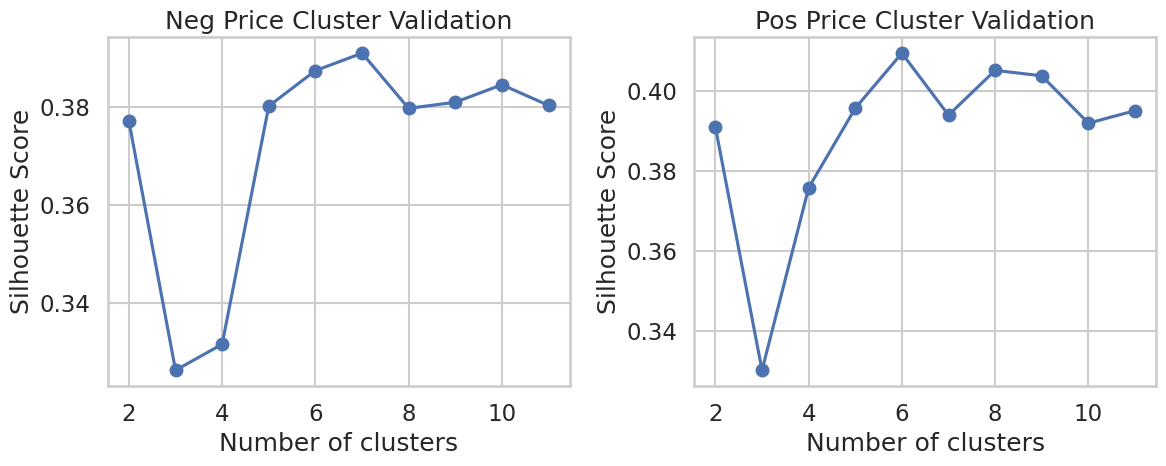

NEG: Optimal number of clusters (Silhouette): 7
POS: Optimal number of clusters (Silhouette): 6


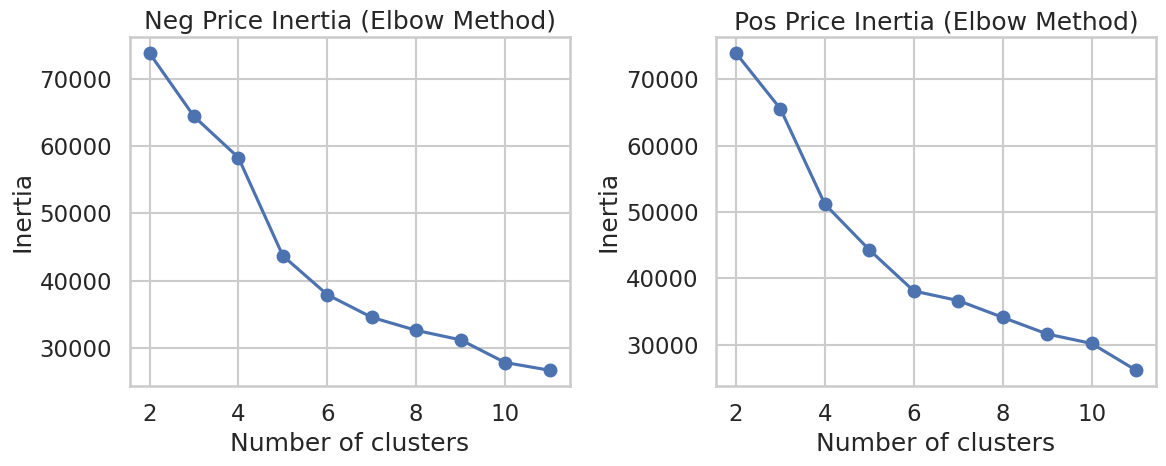

Visually Inspect the elbow from the inertia scores


In [ ]:

def find_best_k(X_scaled):
    range_n_clusters = list(range(2, 12))
    sil_scores = []
    inertias = []
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)
        inertias.append(kmeans.inertia_)
    # Silhouette best: highest score
    best_n_sil = range_n_clusters[np.argmax(sil_scores)]
    return range_n_clusters, sil_scores, inertias, best_n_sil

range_neg, sil_scores_neg, inertia_scores_neg, best_n_neg= find_best_k(X_neg_scaled_df)
range_pos, sil_scores_pos, inertia_scores_pos, best_n_pos= find_best_k(X_pos_scaled_df)

# Plot cluster validation using silhouette scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range_neg, sil_scores_neg, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Neg Price Cluster Validation')

plt.subplot(1, 2, 2)
plt.plot(range_pos, sil_scores_pos, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Pos Price Cluster Validation')
plt.tight_layout()
plt.show()

print(f'NEG: Optimal number of clusters (Silhouette): {best_n_neg}')
print(f'POS: Optimal number of clusters (Silhouette): {best_n_pos}')

# Plot cluster validation using inertia scores (Elbow method)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range_neg, inertia_scores_neg, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Neg Price Inertia (Elbow Method)')

plt.subplot(1, 2, 2)
plt.plot(range_pos, inertia_scores_pos, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Pos Price Inertia (Elbow Method)')
plt.tight_layout()
plt.show()
print("Visually Inspect the elbow from the inertia scores")


After selecting the number of clusters based on the previous analysis, the model is fit to the scaled data and assigned to relevant cluster labels in the original dataframe `df` and then further grouped in cluster profiles (`profile_neg` and `profile_pos`) by calculating the mean of the compact features for each cluster. These profiles are used further to visualize the features on a heatmap, PCA and t-SNE plots.

In [ ]:

kmeans_neg = KMeans(n_clusters=6, random_state=42) # Adjust the number of clusters according to previous analysis
df['cluster_neg'] = kmeans_neg.fit_predict(X_neg_scaled_df)
profile_neg = df.groupby('cluster_neg')[compact_features_neg].mean()

kmeans_pos = KMeans(n_clusters=6, random_state=42) # Adjust the number of clusters according to previous analysis
df['cluster_pos'] = kmeans_pos.fit_predict(X_pos_scaled_df)
profile_pos = df.groupby('cluster_pos')[compact_features_pos].mean()


# Cluster Visualization

A heatmap visualization is implemented here to view the relative effect of the scaled feature values to each other.

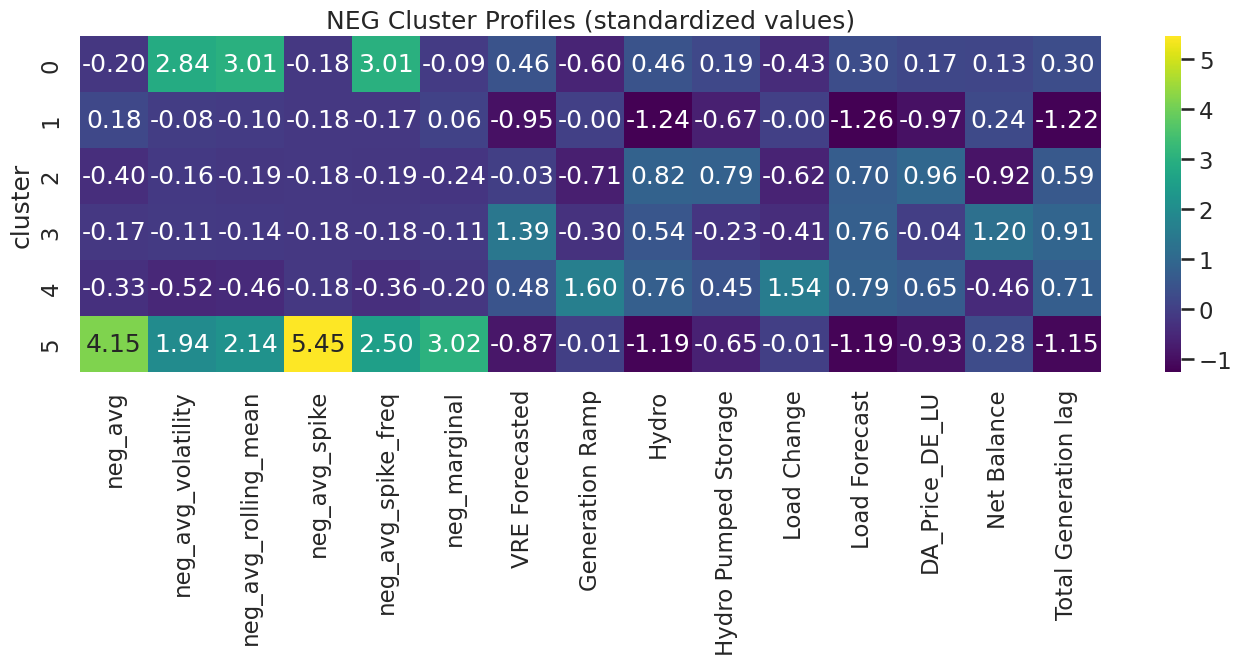

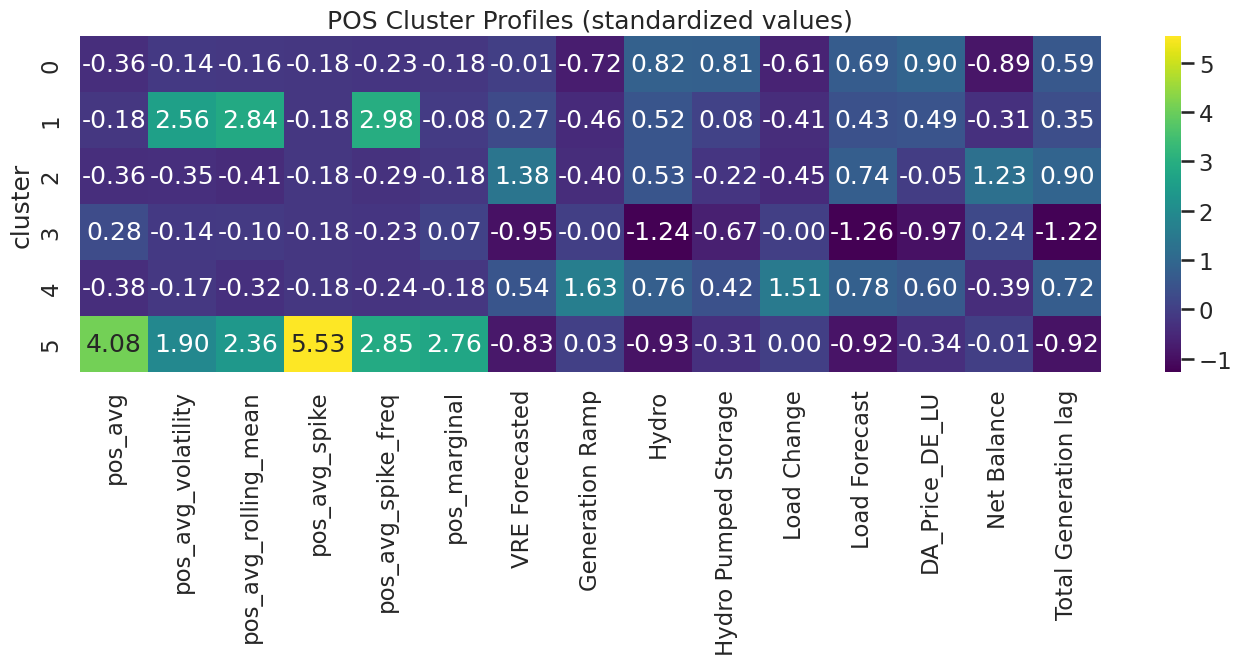

In [ ]:

# Profiles for visualization (scaled values for heatmap)
profile_neg_scaled = X_neg_scaled_df.copy()
profile_neg_scaled['cluster'] = df['cluster_neg']
profile_neg_scaled = profile_neg_scaled.groupby('cluster').mean()

profile_pos_scaled = X_pos_scaled_df.copy()
profile_pos_scaled['cluster'] = df['cluster_pos']
profile_pos_scaled = profile_pos_scaled.groupby('cluster').mean()

# Visualize cluster profiles (standardized values for heatmap)
# Plot NEG cluster profiles
plt.figure(figsize=(14, 7))
sns.heatmap(profile_neg_scaled, annot=True, fmt='.2f', cmap='viridis')
plt.title('NEG Cluster Profiles (standardized values)')
plt.tight_layout()
plt.show()

# Plot POS cluster profiles
plt.figure(figsize=(14, 7))
sns.heatmap(profile_pos_scaled, annot=True, fmt='.2f', cmap='viridis')
plt.title('POS Cluster Profiles (standardized values)')
plt.tight_layout()
plt.show()


PCA and t-SNE plots are executed by using the following functions for visualizing the clustered data in 2 dimensions: `plot_pca` and `plot_tsne`. `plot_pca` performs Principal Component Analysis (PCA) to reduce the dimensionality of the scaled data to 2 components, prints the explained variance ratio of these components, and then creates a scatter plot of the data points colored by their cluster labels in the PCA-reduced space. `plot_tsne` performs t-Distributed Stochastic Neighbor Embedding (t-SNE) to reduce the dimensionality to 2, and then creates a similar scatter plot in the t-SNE-reduced space. Both plots help to visualize the separation and structure of the clusters in a lower-dimensional representation.

In [ ]:

def plot_pca(X_scaled, cluster_labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained = pca.explained_variance_ratio_
    print(f"PC1 explains {explained[0]:.1%} variance; PC2 explains {explained[1]:.1%}")
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cluster_labels, palette='tab10', s=50)
    plt.title(f'PCA: {title}')
    plt.xlabel(f'PC1 ({explained[0]:.1%})')
    plt.ylabel(f'PC2 ({explained[1]:.1%})')
    plt.legend(title='Cluster')
    plt.show()

def plot_tsne(X_scaled, cluster_labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    plt.figure(figsize=(12,12))
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=cluster_labels, palette='tab10', s=50)
    plt.title(f't-SNE: {title}')
    plt.xlabel('tSNE-1')
    plt.ylabel('tSNE-2')
    plt.legend(title='Cluster')
    plt.show()


PC1 explains 34.3% variance; PC2 explains 20.6%


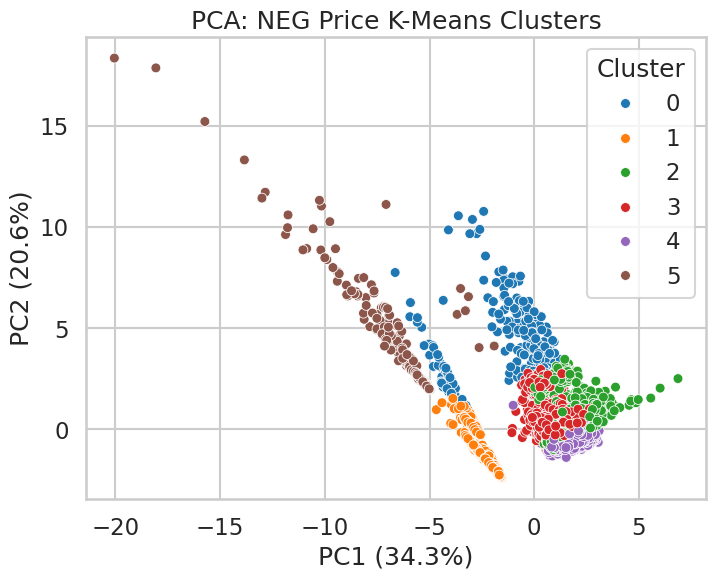

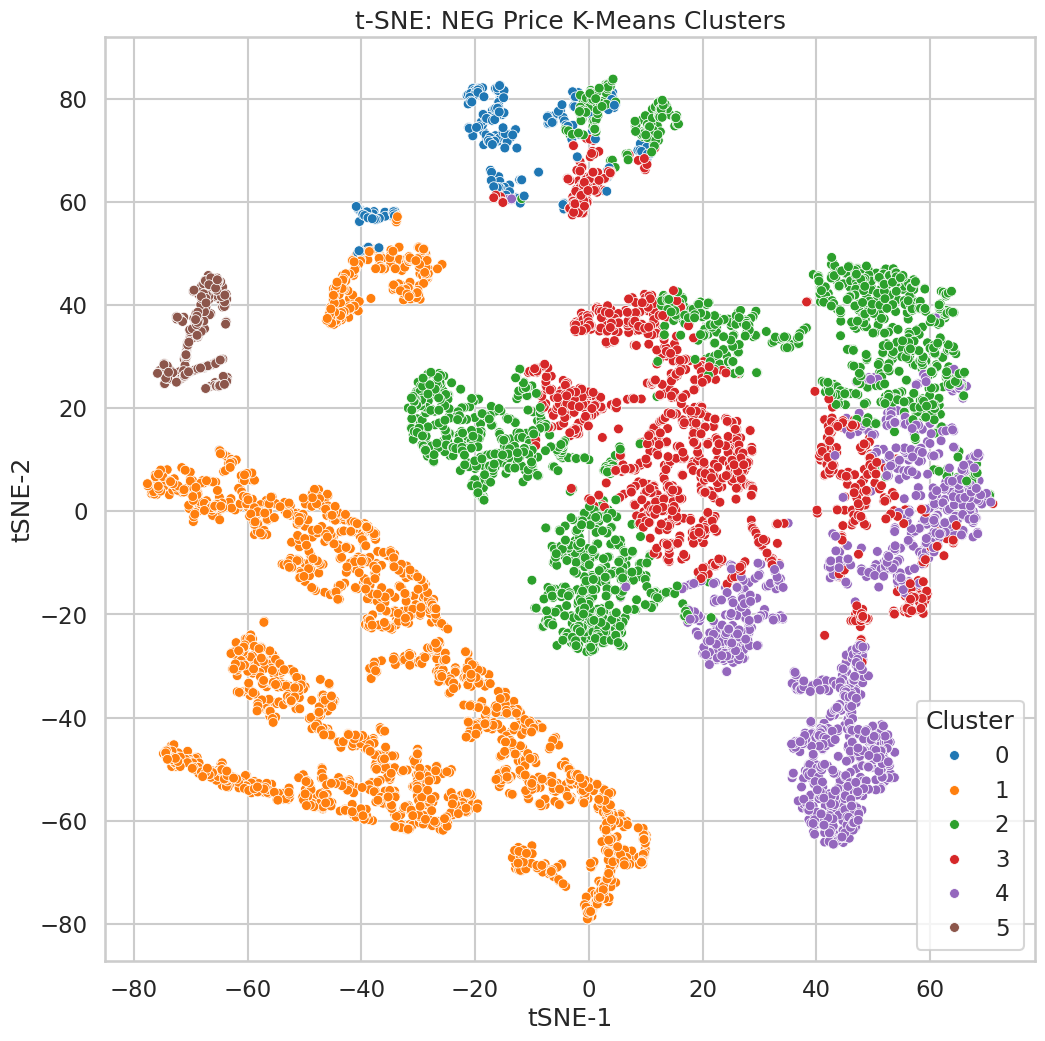

PC1 explains 32.6% variance; PC2 explains 21.7%


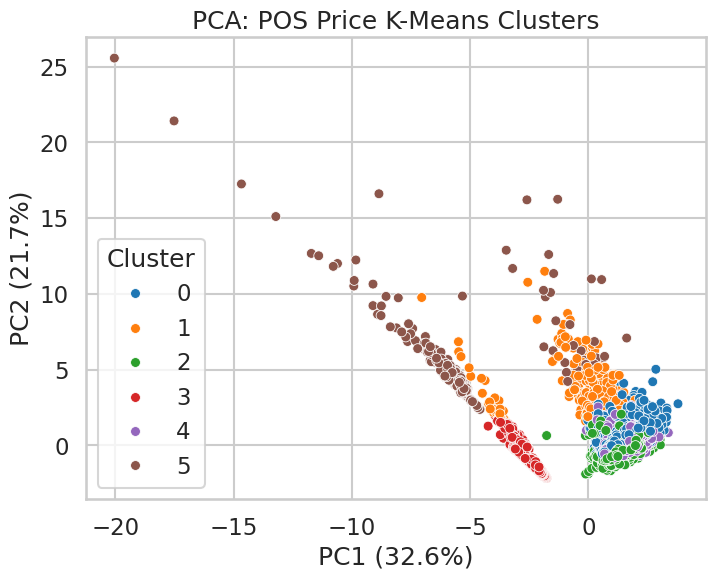

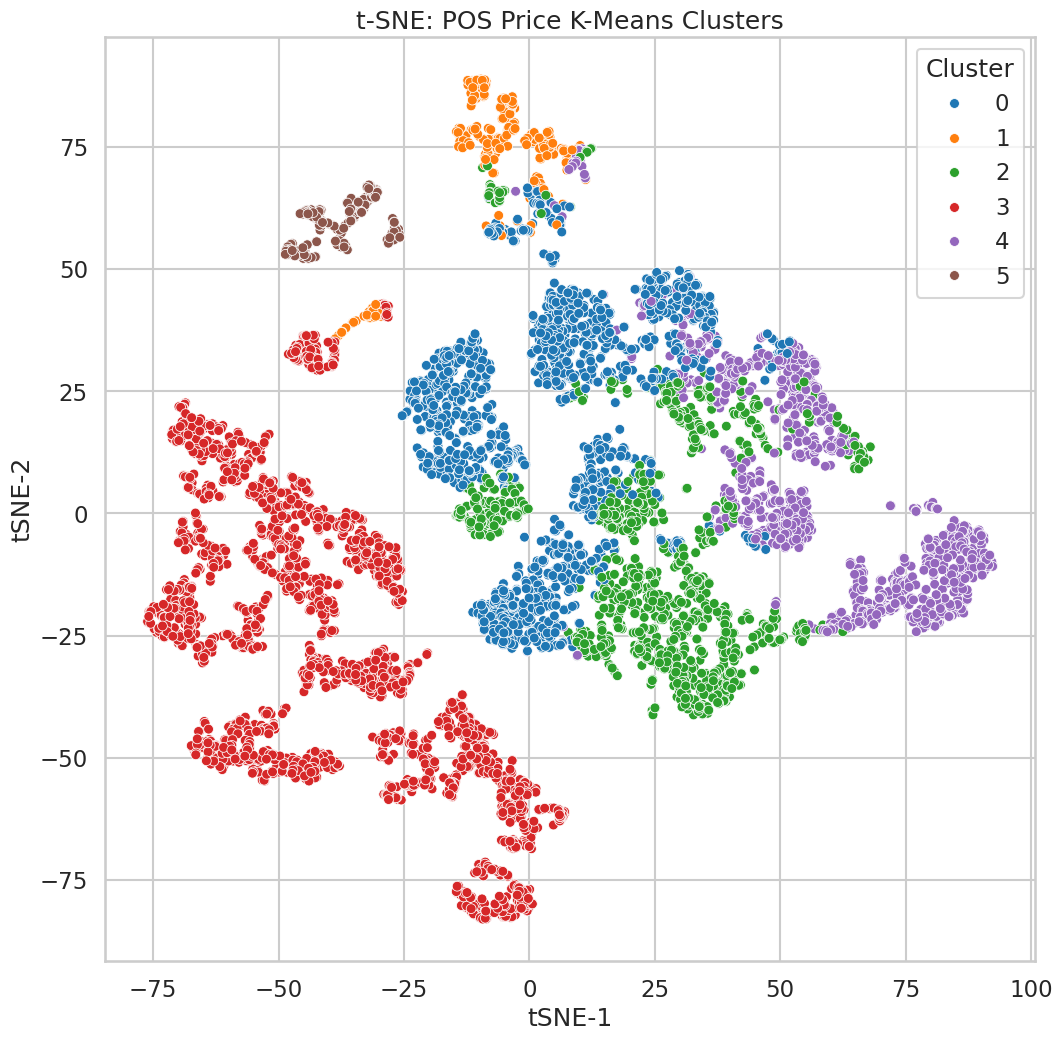

In [ ]:

# PCA and t-SNE plots for K-means Clustering
plot_pca(X_neg_scaled_df, df['cluster_neg'], 'NEG Price K-Means Clusters')
plot_tsne(X_neg_scaled_df, df['cluster_neg'], 'NEG Price K-Means Clusters')

plot_pca(X_pos_scaled_df, df['cluster_pos'], 'POS Price K-Means Clusters')
plot_tsne(X_pos_scaled_df, df['cluster_pos'], 'POS Price K-Means Clusters')


# Regime Interpretation

This code defines a function `regime_interpretation` to provide a reasoned interpretation of the identified clusters (regimes). It iterates through each cluster in the provided profile (which contains the mean feature values for each cluster), prints the mean price behavior and exogenous conditions for that cluster, and then provides a likely interpretation of the regime based on the values of key features like volatility, VRE forecasted generation, lagged prices and generation, net balance, total generation, and load. It then calls this function for both the negative and positive price K-Means cluster profiles.

In [ ]:

def regime_interpretation(profile, price_col, marginal_price, compact_features, label):
    price_cols = [price_col, marginal_price, f'{price_col}_volatility', f'{price_col}_spike_freq']
    exog_cols = [col for col in compact_features if col in [
        'VRE Forecasted', 'Total Generation lag', 'Hydro', 'Hydro Pumped Storage',
        'Net Balance', 'DA_Price_DE_LU', 'Load Change', 'Load Forecast', 'Total Generation'
    ]]
    feature_cols = price_cols + exog_cols

    # Results DataFrame displayed as a table
    print(f"{label} Price Regimes Table:")
    table = profile[feature_cols].copy()
    display(table)

    table['Likely Regime'] = ""

    # Precompute means for regime logic
    volatility_mean = profile[f'{price_col}_volatility'].mean()
    spike_freq_mean = profile[f'{price_col}_spike_freq'].mean()
    marginal_mean = profile[f'{marginal_price}'].mean()
    vre_mean = profile['VRE Forecasted'].mean() if 'VRE Forecasted' in profile.columns else None
    da_mean = profile['DA_Price_DE_LU'].mean() if 'DA_Price_DE_LU' in profile.columns else None
    lagged_gen_mean = profile['Total Generation lag'].mean() if 'Total Generation lag' in profile.columns else None
    net_balance_mean = profile['Net Balance'].mean() if 'Net Balance' in profile.columns else None
    total_gen_mean = profile['Total Generation'].mean() if 'Total Generation' in profile.columns else None
    load_forecast_mean = profile['Load Forecast'].mean() if 'Load Forecast' in profile.columns else None
    load_change_mean = profile['Load Change'].mean() if 'Load Change' in profile.columns else None

    for c in profile.index:
      volatility = profile.loc[c, f'{price_col}_volatility']
      spike_freq = profile.loc[c, f'{price_col}_spike_freq']
      marginal_val = profile.loc[c, marginal_price]
      vre = profile.loc[c, 'VRE Forecasted'] if 'VRE Forecasted' in profile.columns else None
      da_price = profile.loc[c, 'DA_Price_DE_LU'] if 'DA_Price_DE_LU' in profile.columns else None
      lagged_gen = profile.loc[c, 'Total Generation lag'] if 'Total Generation lag' in profile.columns else None
      net_balance = profile.loc[c, 'Net Balance'] if 'Net Balance' in profile.columns else None
      total_gen = profile.loc[c, 'Total Generation'] if 'Total Generation' in profile.columns else None
      load_forecast = profile.loc[c, 'Load Forecast'] if 'Load Forecast' in profile.columns else None
      load_change = profile.loc[c, 'Load Change'] if 'Load Change' in profile.columns else None

      # Regime logic
      regime = ""
      if pd.notna(volatility) and pd.notna(spike_freq) and volatility > 2 * volatility_mean and spike_freq > 1.5 * spike_freq_mean:
        regime += "High market stress volatility and spikes, "
      if pd.notna(volatility) and volatility > 1.5 * volatility_mean and pd.notna(load_change) and abs(load_change) > 1.5 * load_change_mean:
          regime += "Ramping-induced volatility, "
      if pd.notna(vre) and vre > vre_mean and pd.notna(net_balance) and net_balance > 0:
          regime += "High VRE surplus, "
      if pd.notna(da_price) and pd.notna(marginal_val):
        if (da_price > da_mean and marginal_val > marginal_mean) or (marginal_val > da_price > 0):
          regime += "Opportunity cost, "
      if pd.notna(lagged_gen) and lagged_gen < lagged_gen_mean:
          regime += "Low previous day gen, lagged price pressure, "
      if pd.notna(net_balance) and net_balance < 0:
          regime += "Demand exceeds generation, "
      if pd.notna(total_gen) and total_gen > total_gen_mean:
          regime += "High gen, price-moderating, "
      if pd.notna(load_forecast) and load_forecast > load_forecast_mean:
          regime += "High demand forecast, "
      if not regime:
          regime += "Normal or structural pattern "
      table.loc[c, 'Likely Regime'] = regime

    print("\nLikely Regimes by Cluster:")
    for idx, val in table['Likely Regime'].items():
      print(f"{idx}: {val}")

regime_interpretation(profile_neg, 'neg_avg', 'neg_marginal', compact_features_neg, 'NEG (k-means)')
regime_interpretation(profile_pos, 'pos_avg', 'pos_marginal', compact_features_pos, 'POS (k-means)')


NEG (k-means) Price Regimes Table:


,neg_avg,neg_marginal,neg_avg_volatility,neg_avg_spike_freq,VRE Forecasted,...,Load Change,Load Forecast,DA_Price_DE_LU,Net Balance,Total Generation lag
cluster_neg,,,,,,,,,,,
0,24.963571,45.026964,51.433712,1.706107,26125.815713,...,-217.477220,50656.277161,78.815713,-723.584404,48708.671729
1,12.477768,17.565065,10.806635,0.106614,NaN,...,NaN,NaN,NaN,NaN,NaN
2,4.379148,5.684977,9.645031,0.095506,13991.457654,...,-253.993153,51926.696746,109.047831,-6581.877598,47502.350478
3,10.877300,15.836357,10.333357,0.099364,35518.496025,...,-169.499172,53298.245380,52.604336,5459.763414,55949.585445
4,6.829676,9.756501,4.661859,0.008873,21717.034716,...,632.769743,54093.497005,91.560375,-3946.517913,50603.169754
5,87.249238,171.463049,38.914573,1.448430,38770.723214,...,-89.687500,59609.660714,72.880714,8085.160714,58193.571429



Likely Regimes by Cluster:
0: High market stress volatility and spikes, Ramping-induced volatility, Low previous day gen, lagged price pressure, Demand exceeds generation, 
1: Normal or structural pattern 
2: Low previous day gen, lagged price pressure, Demand exceeds generation, 
3: High VRE surplus, 
4: Low previous day gen, lagged price pressure, Demand exceeds generation, High demand forecast, 
5: Ramping-induced volatility, High VRE surplus, Opportunity cost, High demand forecast, 
POS (k-means) Price Regimes Table:


,pos_avg,pos_marginal,pos_avg_volatility,pos_avg_spike_freq,VRE Forecasted,...,Load Change,Load Forecast,DA_Price_DE_LU,Net Balance,Total Generation lag
cluster_pos,,,,,,,,,,,
0,9.508513,12.222092,6.626631,0.061844,14292.332774,...,-251.949096,51696.137082,105.760535,-6403.473053,47409.509961
1,22.165238,34.105595,33.262100,1.886731,21623.841255,...,-196.992871,52472.572719,97.227833,-3664.528517,48492.241920
2,5.997959,7.612417,4.542522,0.025974,35297.009030,...,-183.674276,53013.390321,52.100450,5633.941863,55819.418755
3,12.957636,16.310774,6.620429,0.060593,NaN,...,NaN,NaN,NaN,NaN,NaN
4,7.982854,10.207190,6.351024,0.051483,22570.484293,...,619.809773,54069.077880,88.992982,-3562.803992,50847.585678
5,69.383727,149.368136,26.743554,1.813636,12537.471774,...,8.399194,65053.846774,252.531452,-10066.308468,56276.933468



Likely Regimes by Cluster:
0: Low previous day gen, lagged price pressure, Demand exceeds generation, 
1: High market stress volatility and spikes, Ramping-induced volatility, Low previous day gen, lagged price pressure, Demand exceeds generation, 
2: High VRE surplus, 
3: Normal or structural pattern 
4: Low previous day gen, lagged price pressure, Demand exceeds generation, 
5: Ramping-induced volatility, Opportunity cost, Demand exceeds generation, High demand forecast, 


# Agglomerative Clustering ("Ward" Method)

This code defines a function `hierarchical_clustering` to perform Agglomerative hierarchical clustering and find the optimal number of clusters using the silhouette score. It takes scaled data, maximum number of clusters, and linkage method "ward" as input. It iterates through a range of cluster numbers, performs Agglomerative Clustering, calculates the silhouette score, and plots the silhouette scores for different numbers of clusters. It then identifies and prints the number of clusters with the highest silhouette score as the best number of clusters.

In [ ]:

# Hierarchical Clustering
def hierarchical_clustering(X_scaled, max_clusters=12, method='ward'):
    sil_scores = []
    cluster_range = range(2, max_clusters)
    for k in cluster_range:
        model = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = model.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels)
        sil_scores.append(sil)
    plt.plot(list(cluster_range), sil_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f'Hierarchical clustering ({method}) validation')
    plt.show()
    best_k = cluster_range[np.argmax(sil_scores)]
    print(f'Best number of clusters:', best_k)
    return best_k

NEG Hierarchical silhouette scores


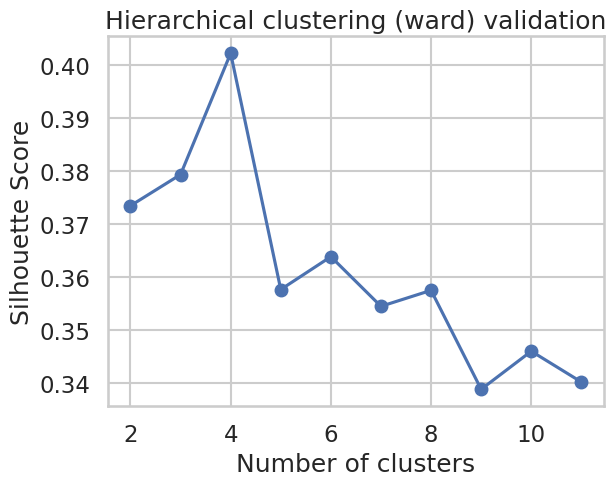

Best number of clusters: 4
POS Hierarchical silhouette scores


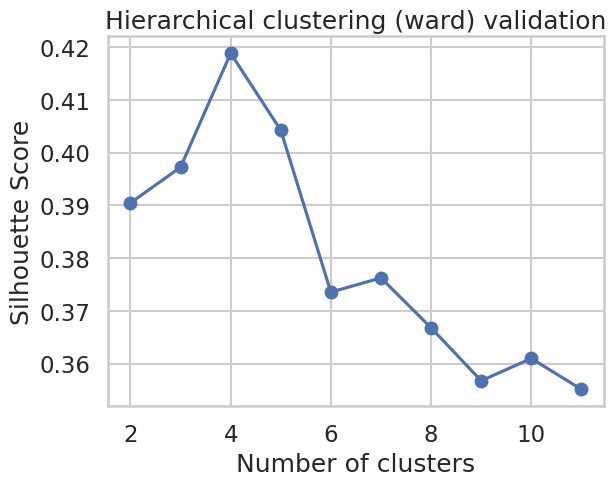

Best number of clusters: 4


In [ ]:

# Silhouette Scores
print("NEG Hierarchical silhouette scores")
best_k_neg_hier = hierarchical_clustering(X_neg_scaled_df, method='ward')

print("POS Hierarchical silhouette scores")
best_k_pos_hier = hierarchical_clustering(X_pos_scaled_df, method='ward')


This code defines a function `plot_dendrogram` to visualize the hierarchical clustering process as a dendrogram. It takes scaled data, linkage method, and optional truncation parameters as input. It computes the linkage matrix, then plots the dendrogram, showing how clusters are merged at different distance levels. Truncation can be used to show only the last `p` merges or to show merges at a specific level. The function returns the linkage matrix. It then calls this function to plot dendrograms for both negative and positive price features using the 'ward' linkage method and truncating to the last 12 merges.

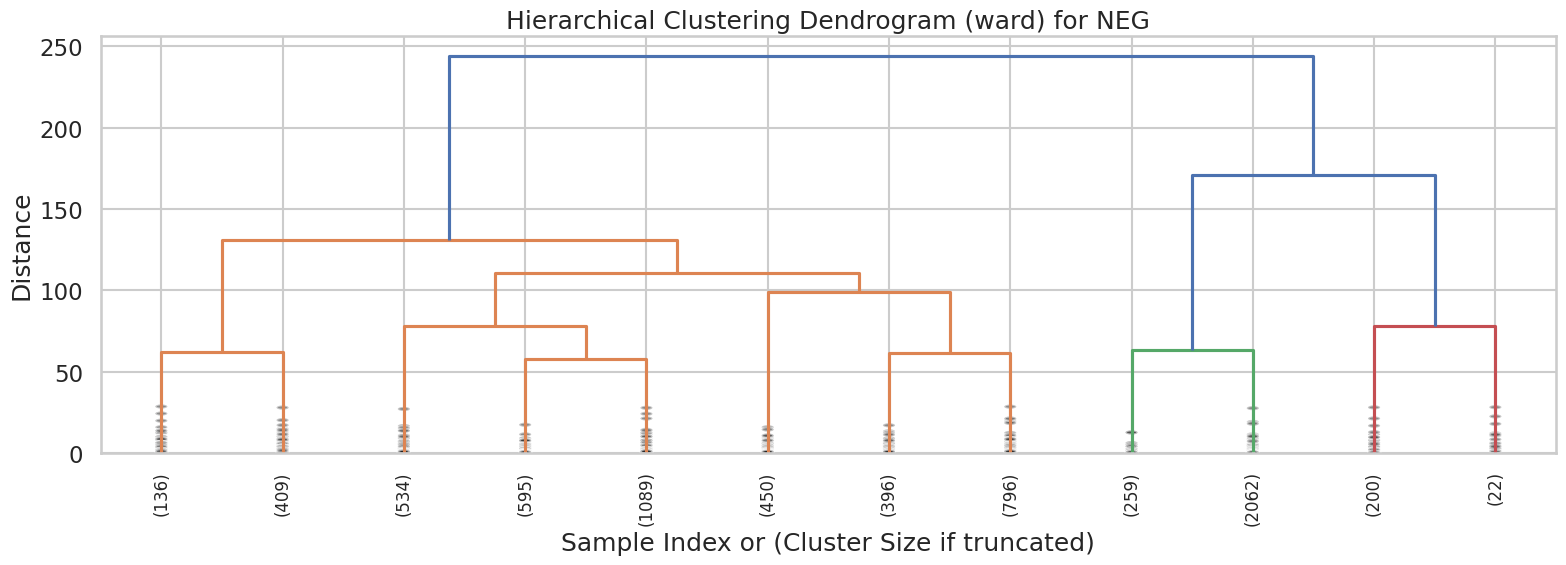

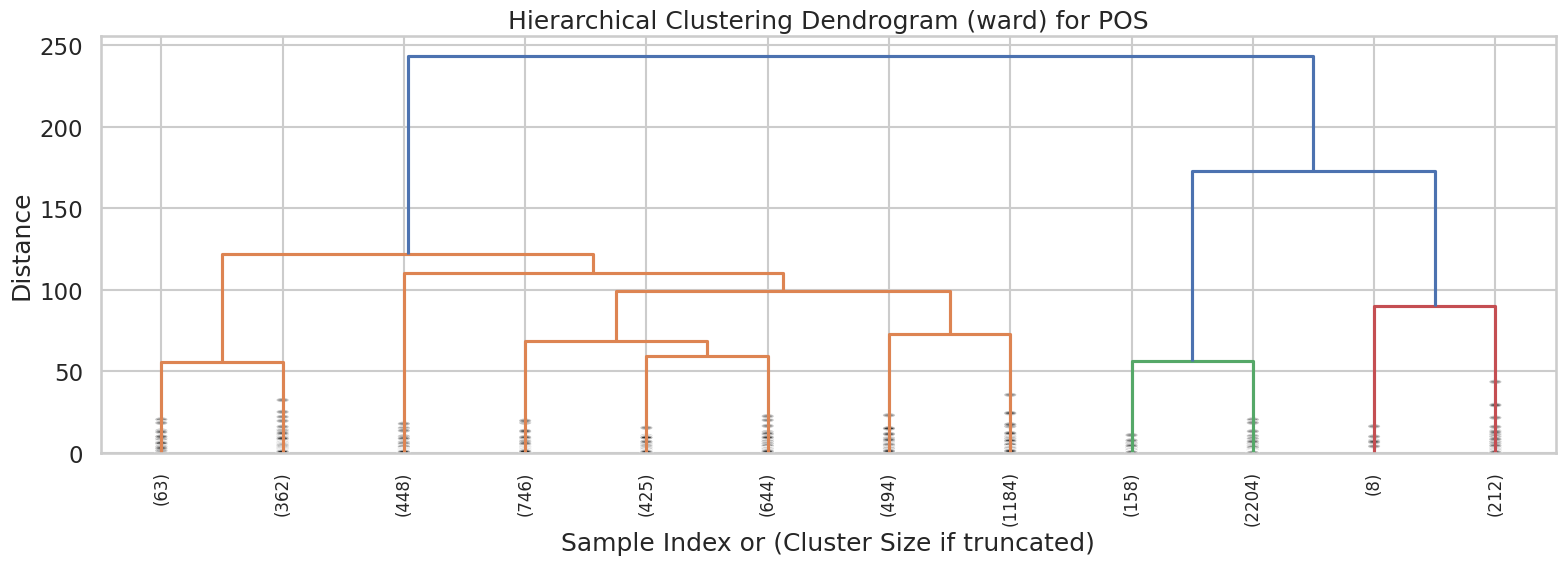

In [ ]:

def plot_dendrogram(X_scaled, label, method='ward'):
    # Compute the linkage matrix
    Z = linkage(X_scaled, method=method)

    plt.figure(figsize=(16, 6))
    dendrogram(
        Z,
        truncate_mode='lastp',
        p=12,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        color_threshold=None
    )
    plt.title(f'Hierarchical Clustering Dendrogram ({method}) for {label}')
    plt.xlabel('Sample Index or (Cluster Size if truncated)')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()
    return Z

Z_neg = plot_dendrogram(X_neg_scaled_df, 'NEG', method='ward')
Z_pos = plot_dendrogram(X_pos_scaled_df, 'POS', method='ward')

This cell performs Agglomerative Clustering with the chosen number of clusters (based on previous analysis through visual inspection of the dendrogram/silhouette scores). It fits the Agglomerative Clustering models to the scaled data and assigns the resulting cluster labels to new columns 'cluster_neg_hier' and 'cluster_pos_hier' in copies of the original feature dataframes (`neg_cluster_df` and `pos_cluster_df`). It then groups these dataframes by the hierarchical cluster labels and calculates the mean of the original features to get cluster profiles (`profile_neg_hier` and `profile_pos_hier`). It also creates scaled versions of these dataframes and calculates scaled mean profiles (`profile_neg_hier_scaled` and `profile_pos_hier_scaled`) for heatmap visualization, which are then plotted as heatmaps to visualize the average standardized feature values within each hierarchical cluster.

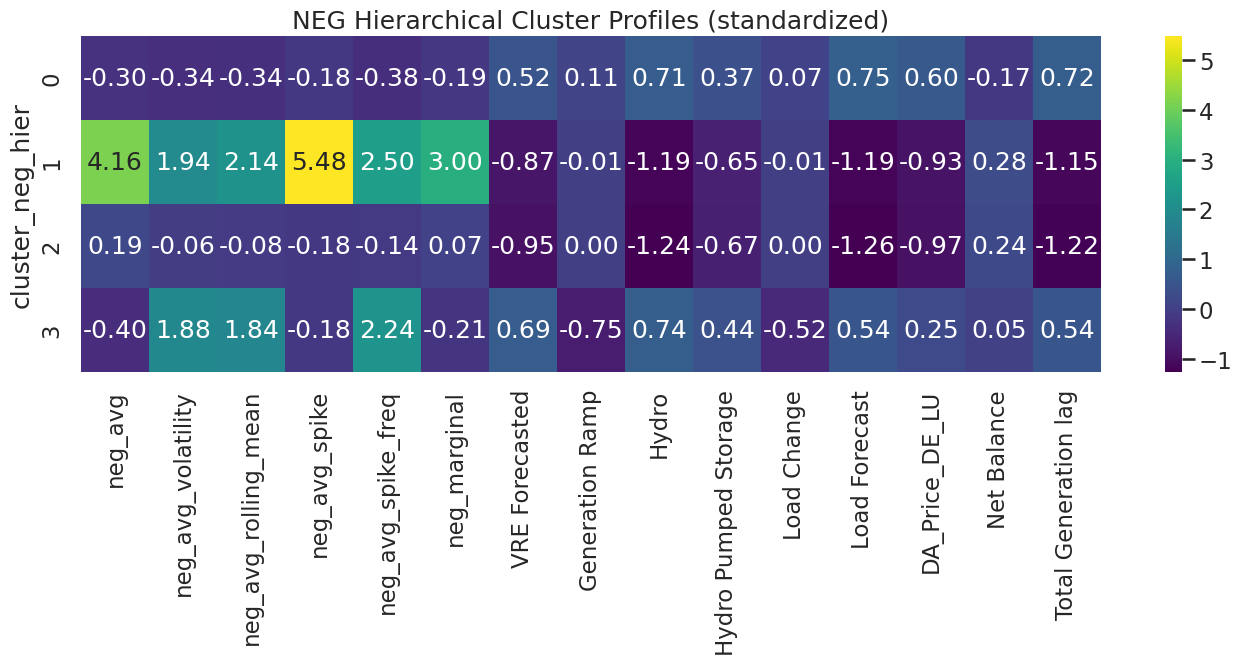

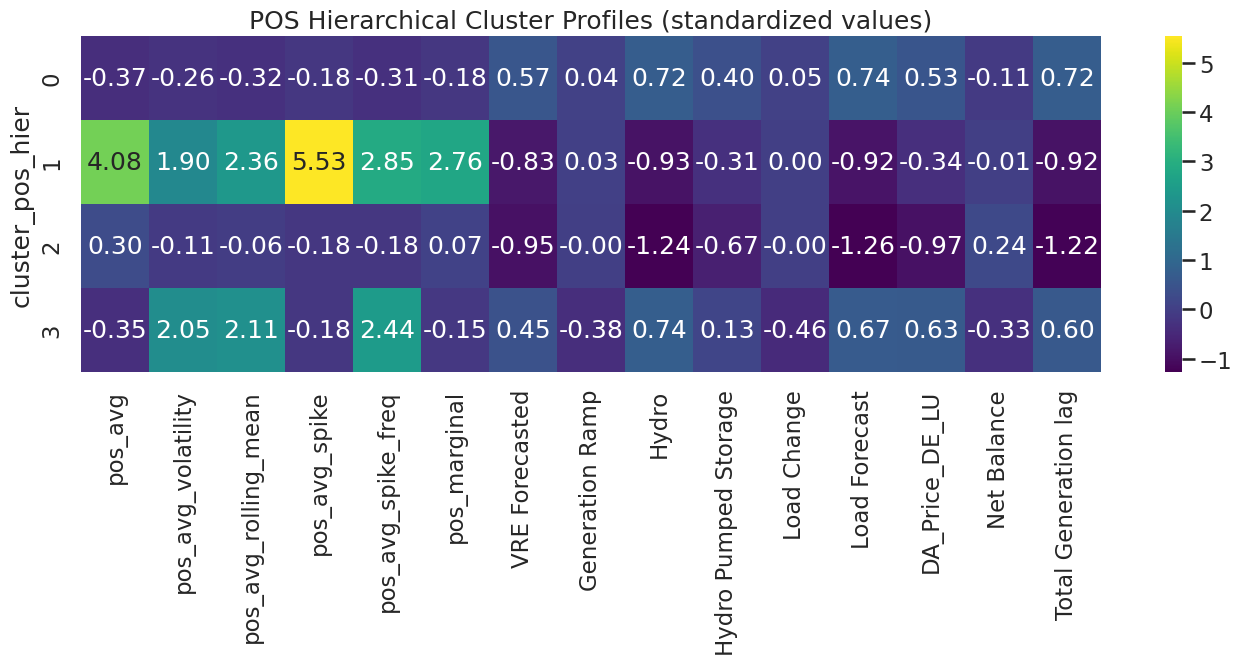

In [ ]:

# Cluster Profiles (Select number of clusters using silhouette scores or dendogram)
n_clusters_neg = 4
neg_model = AgglomerativeClustering(n_clusters=n_clusters_neg, linkage='ward')
labels_neg_hier = neg_model.fit_predict(X_neg_scaled_df)

n_clusters_pos = 4
pos_model = AgglomerativeClustering(n_clusters=n_clusters_pos, linkage='ward')
labels_pos_hier = pos_model.fit_predict(X_pos_scaled_df)

# Create DataFrames with original values and cluster assignment
neg_cluster_df = pd.DataFrame(X_neg, index=X_neg.index, columns=compact_features_neg)
neg_cluster_df['cluster_neg_hier'] = labels_neg_hier
profile_neg_hier = neg_cluster_df.groupby('cluster_neg_hier').mean()

pos_cluster_df = pd.DataFrame(X_pos, index=X_pos.index, columns=compact_features_pos)
pos_cluster_df['cluster_pos_hier'] = labels_pos_hier
profile_pos_hier = pos_cluster_df.groupby('cluster_pos_hier').mean()

# Use scaled features for compact heatmap visual
neg_cluster_df_scaled = X_neg_scaled_df.copy()
neg_cluster_df_scaled['cluster_neg_hier'] = labels_neg_hier
profile_neg_hier_scaled = neg_cluster_df_scaled.groupby('cluster_neg_hier').mean()

pos_cluster_df_scaled = X_pos_scaled_df.copy()
pos_cluster_df_scaled['cluster_pos_hier'] = labels_pos_hier
profile_pos_hier_scaled = pos_cluster_df_scaled.groupby('cluster_pos_hier').mean()

# Visualize cluster profiles (standardized values for heatmap)
# Plot NEG cluster profiles
plt.figure(figsize=(14, 7))
sns.heatmap(profile_neg_hier_scaled, annot=True, fmt='.2f', cmap='viridis')
plt.title('NEG Hierarchical Cluster Profiles (standardized)')
plt.tight_layout()
plt.show()

# Plot POS cluster profiles
plt.figure(figsize=(14, 7))
sns.heatmap(profile_pos_hier_scaled, annot=True, fmt='.2f', cmap='viridis')
plt.title('POS Hierarchical Cluster Profiles (standardized values)')
plt.tight_layout()
plt.show()


PC1 explains 34.3% variance; PC2 explains 20.6%


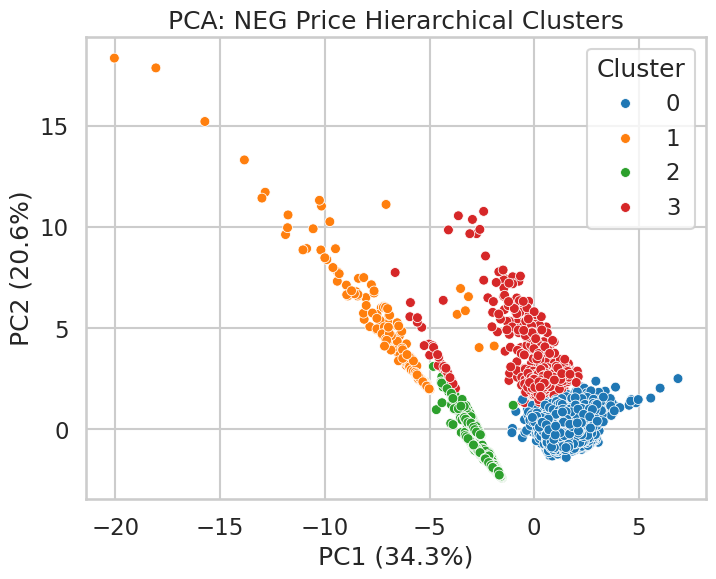

KeyboardInterrupt: 

In [ ]:

# PCA and t-SNE plots for Hierarchical Clustering
plot_pca(X_neg_scaled_df, labels_neg_hier, 'NEG Price Hierarchical Clusters')
plot_tsne(X_neg_scaled_df, labels_neg_hier, 'NEG Price Hierarchical Clusters')

plot_pca(X_pos_scaled_df, labels_pos_hier, 'POS Price Hierarchical Clusters')
plot_tsne(X_pos_scaled_df, labels_pos_hier, 'POS Price Hierarchical Clusters')


This cell provides a reasoned interpretation of the hierarchical clustering results for both negative and positive aFRR prices. It uses the `regime_interpretation` function, which was previously defined, to analyze the mean feature values within each hierarchical cluster (`profile_neg_hier` and `profile_pos_hier`) and provide a likely characterization of the market conditions or "regime" represented by each cluster based on key price behavior and exogenous factors.

In [ ]:

# Regime interpretation for Hierarchical Clustering
regime_interpretation(profile_neg_hier, 'neg_avg', 'neg_marginal', compact_features_neg, 'NEG (Hierarchical)')
regime_interpretation(profile_pos_hier, 'pos_avg', 'pos_marginal', compact_features_pos, 'POS (Hierarchical)')


NEG (Hierarchical) Price Regimes Table:


,neg_avg,neg_marginal,neg_avg_volatility,neg_avg_spike_freq,VRE Forecasted,Hydro,Hydro Pumped Storage,Load Change,Load Forecast,DA_Price_DE_LU,Net Balance,Total Generation lag
cluster_neg_hier,,,,,,,,,,,,
0,3.474658,4.722308,7.077237,0.000518,22284.832529,1841.749951,1156.520094,29.853897,53181.698710,88.801111,-2298.037387,50984.163293
1,87.418694,170.577748,38.968903,1.450450,1222.500282,53.155124,17.925394,-2.827984,1879.583896,2.298041,254.937500,1834.932432
2,12.680832,18.189841,11.047745,0.120207,34.126616,1.322571,0.677052,0.656452,48.304206,0.048533,1.021731,36.638006
3,1.487725,3.616220,38.141800,1.315596,24870.502523,1869.548853,1232.934518,-211.937729,47502.855505,68.718468,-1067.669037,46203.730275



Likely Regimes by Cluster:
0: Demand exceeds generation, High demand forecast, 
1: Ramping-induced volatility, Opportunity cost, Low previous day gen, lagged price pressure, 
2: Opportunity cost, Low previous day gen, lagged price pressure, 
3: Ramping-induced volatility, Demand exceeds generation, High demand forecast, 
POS (Hierarchical) Price Regimes Table:


,pos_avg,pos_marginal,pos_avg_volatility,pos_avg_spike_freq,VRE Forecasted,Hydro,Hydro Pumped Storage,Load Change,Load Forecast,DA_Price_DE_LU,Net Balance,Total Generation lag
cluster_pos_hier,,,,,,,,,,,,
0,3.291307,4.204479,5.469258,0.011165,22971.429888,1847.708688,1186.865009,20.529191,52770.485621,84.873023,-1956.067416,50852.081182
1,69.383727,149.368136,26.743554,1.813636,1766.643750,295.500852,392.615057,1.183523,9166.678409,35.583977,-1418.434375,7929.931534
2,13.161774,16.595648,6.929659,0.087214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.593412,5.658871,28.211035,1.578824,21189.208382,1873.173971,889.076324,-189.506176,51093.275000,90.667312,-3229.221471,47810.960588



Likely Regimes by Cluster:
0: Demand exceeds generation, High demand forecast, 
1: Ramping-induced volatility, Opportunity cost, Low previous day gen, lagged price pressure, Demand exceeds generation, 
2: Low previous day gen, lagged price pressure, 
3: Ramping-induced volatility, Demand exceeds generation, High demand forecast, 


# Cluster Interpretation

The following cells prepare data and generate bar plots to visualize the mean scaled feature values for each cluster obtained from both K-Means and Agglomerative Clustering for the negative and positive aFRR prices. It copies the scaled negative feature data, adds the K-Means and Agglomerative cluster labels, groups by cluster, calculates the mean scaled feature values for each cluster, and then creates bar plots for both clustering methods to compare the profiles of the clusters in terms of standardized feature values.

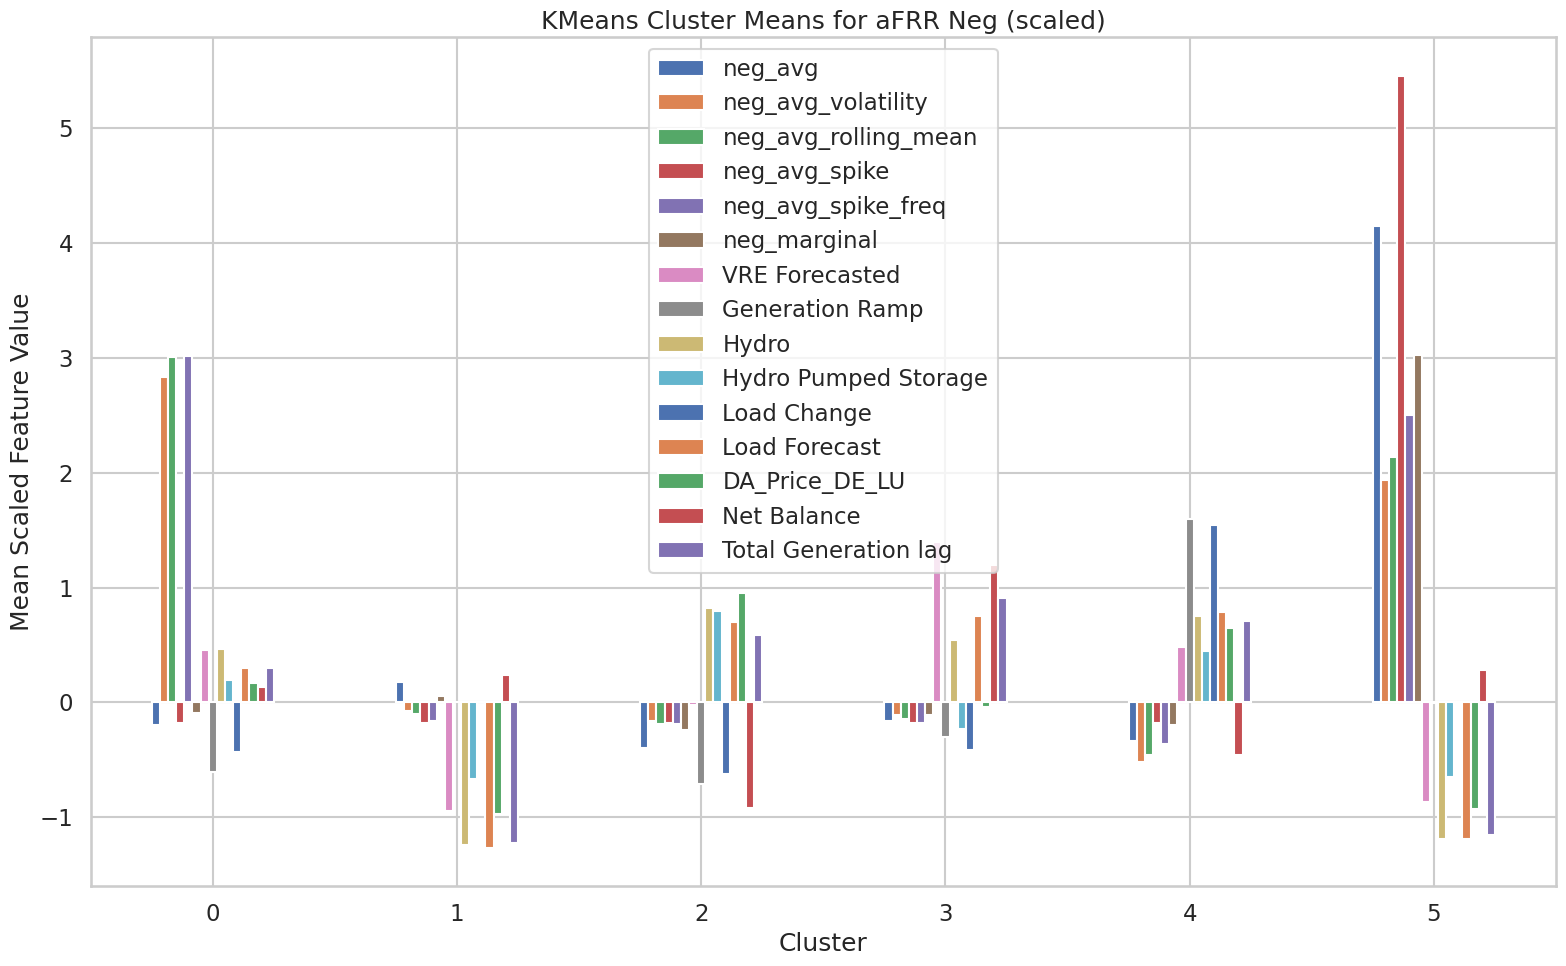

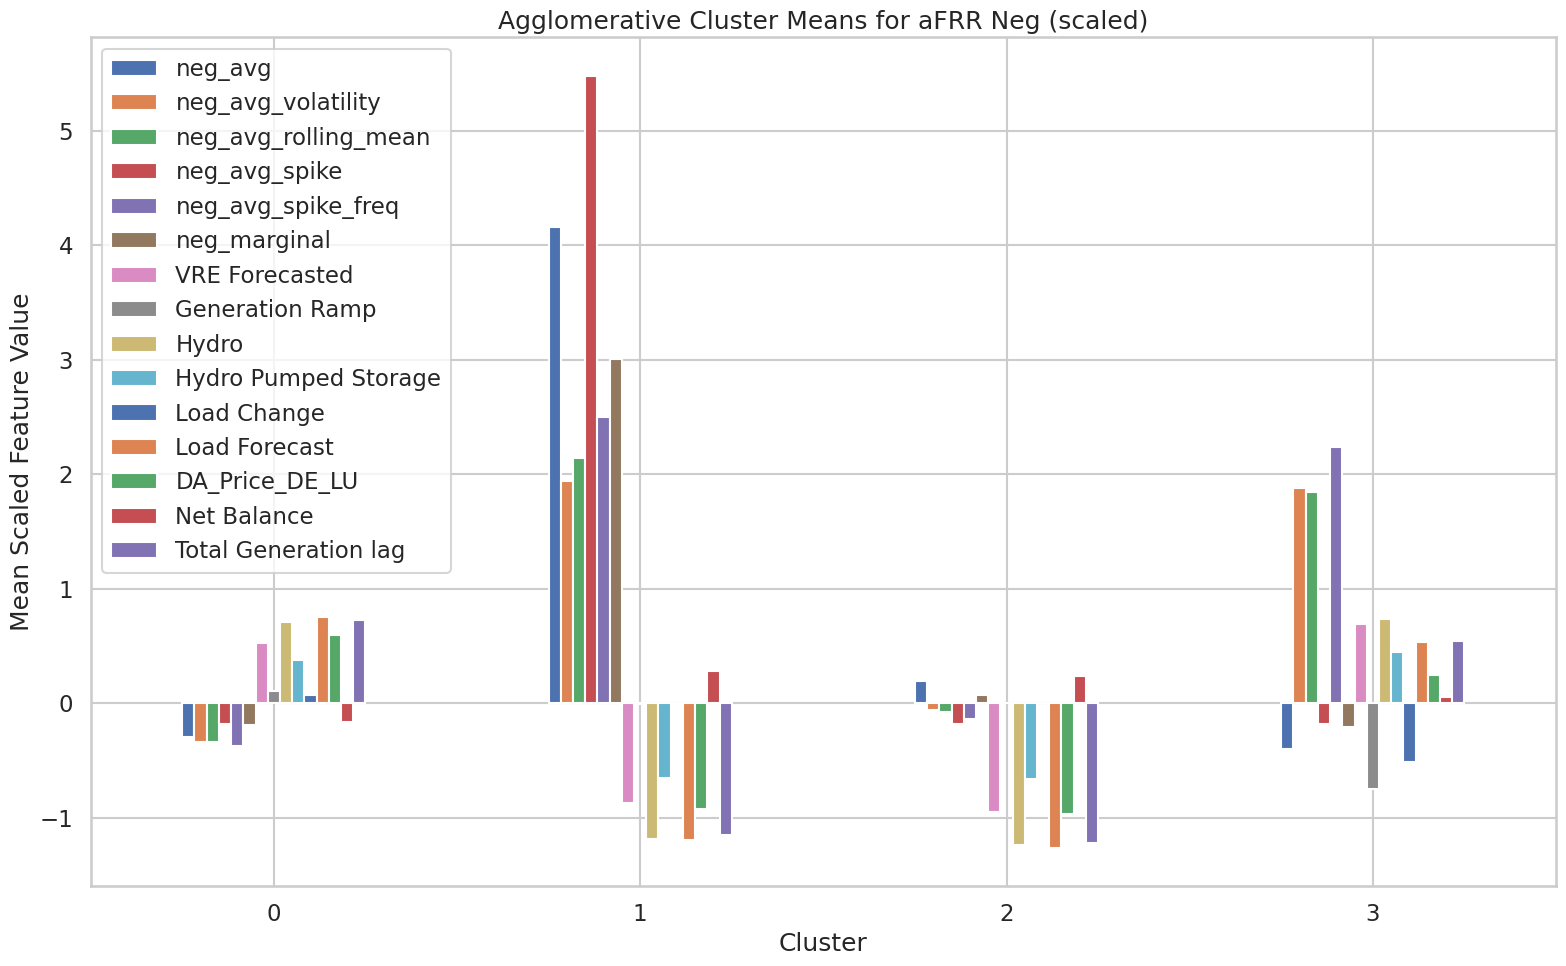

In [ ]:

# For NEG aFRR
clustered_kmeans_neg = X_neg_scaled_df.copy()
clustered_kmeans_neg['cluster_neg'] = df['cluster_neg']  # KMeans cluster labels

clustered_agg_neg = X_neg_scaled_df.copy()
clustered_agg_neg['cluster_neg_hier'] = labels_neg_hier

# KMeans
profile_neg_scaled = clustered_kmeans_neg.groupby('cluster_neg').mean()

profile_neg_scaled.plot(kind='bar', figsize=(16, 10))
plt.title("KMeans Cluster Means for aFRR Neg (scaled)")
plt.xlabel("Cluster")
plt.ylabel("Mean Scaled Feature Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Agglomerative
profile_agg_scaled_neg = clustered_agg_neg.groupby('cluster_neg_hier').mean()

profile_agg_scaled_neg.plot(kind='bar', figsize=(16, 10))
plt.title("Agglomerative Cluster Means for aFRR Neg (scaled)")
plt.xlabel("Cluster")
plt.ylabel("Mean Scaled Feature Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


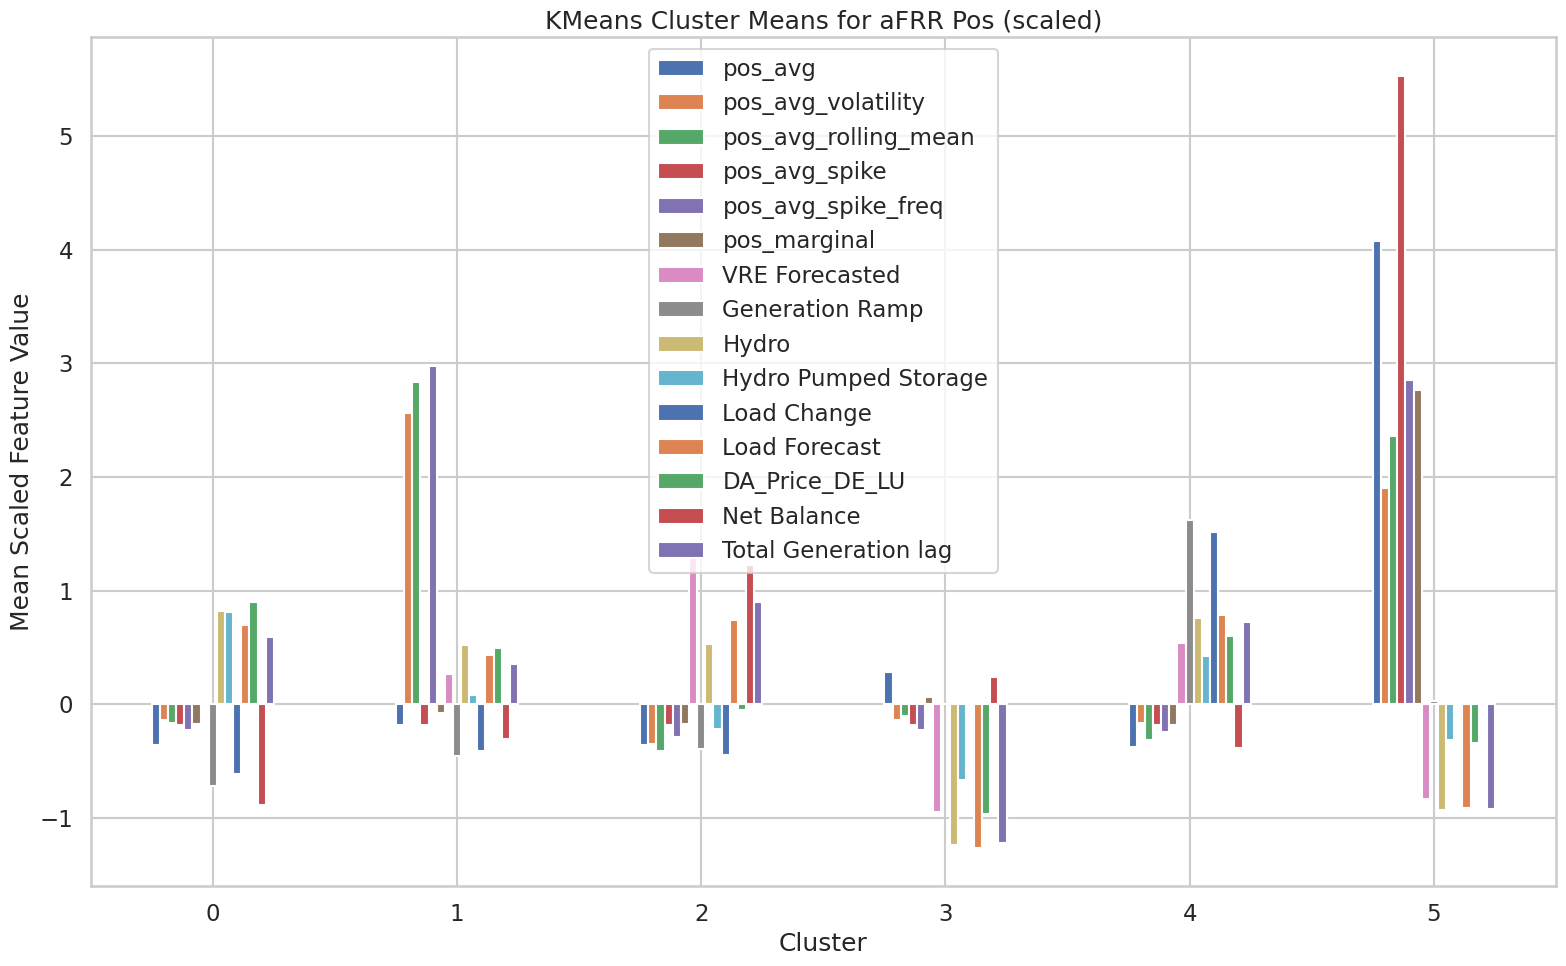

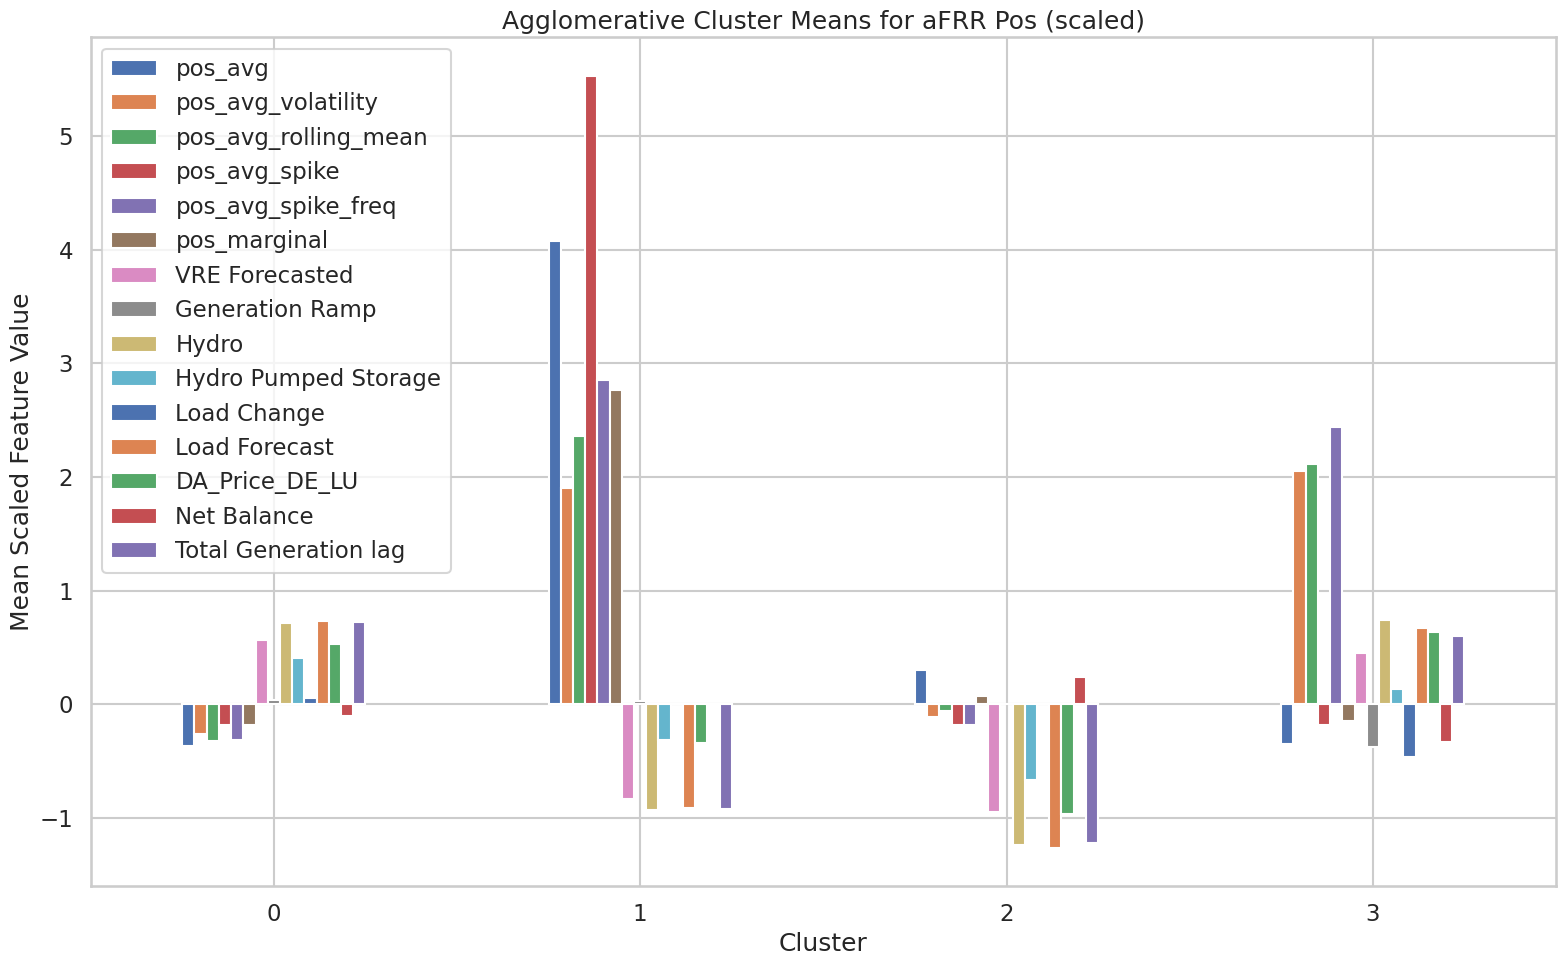

In [ ]:

# For POS aFRR
clustered_kmeans_pos = X_pos_scaled_df.copy()
clustered_kmeans_pos['cluster_pos'] = df['cluster_pos']  # KMeans cluster labels

clustered_agg_pos = X_pos_scaled_df.copy()
clustered_agg_pos['cluster_pos_hier'] = labels_pos_hier

# KMeans
profile_pos_scaled = clustered_kmeans_pos.groupby('cluster_pos').mean()

profile_pos_scaled.plot(kind='bar', figsize=(16, 10))
plt.title("KMeans Cluster Means for aFRR Pos (scaled)")
plt.xlabel("Cluster")
plt.ylabel("Mean Scaled Feature Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Agglomerative
profile_agg_scaled_pos = clustered_agg_pos.groupby('cluster_pos_hier').mean()

profile_agg_scaled_pos.plot(kind='bar', figsize=(16, 10))
plt.title("Agglomerative Cluster Means for aFRR Pos (scaled)")
plt.xlabel("Cluster")
plt.ylabel("Mean Scaled Feature Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Principal Component Analysis (PCA)

This cell performs Principal Component Analysis (PCA) on the scaled negative and positive price feature data. It fits PCA models to the scaled data to identify the principal components (linear combinations of original features that capture the most variance). It then calculates the explained variance ratio of each component (how much variance each component explains) and the loadings (the contribution of each original feature to each principal component). It prints the explained variance ratio and the loadings for the first two principal components (PC1 and PC2, which are the most important ones) for both negative and positive prices. Finally, it generates bar plots to visualize the loadings of PC1 and PC2 for each feature, helping to understand which features contribute most to these principal components.

Explained variance ratio (NEG): ['0.3431', '0.2062', '0.1218', '0.1120', '0.0779', '0.0344', '0.0309', '0.0195', '0.0164', '0.0138', '0.0093', '0.0053', '0.0048', '0.0035', '0.0011']

Feature loadings for PC1 & PC2:
                         PC1     PC2
Load Forecast         0.3860  0.2411
Hydro                 0.3694  0.2405
Total Generation lag  0.3678  0.2398
DA_Price_DE_LU        0.3311  0.1721
neg_avg              -0.3089  0.2063
Hydro Pumped Storage  0.2604  0.1780
VRE Forecasted        0.2555  0.2218
neg_avg_spike        -0.2326  0.2519
neg_marginal         -0.2250  0.2158
neg_avg_rolling_mean -0.2051  0.4342
neg_avg_volatility   -0.2038  0.4089
neg_avg_spike_freq   -0.1865  0.4123
Net Balance          -0.1221 -0.0061
Generation Ramp       0.0406 -0.1496
Load Change           0.0377 -0.1237


<Figure size 1200x600 with 0 Axes>

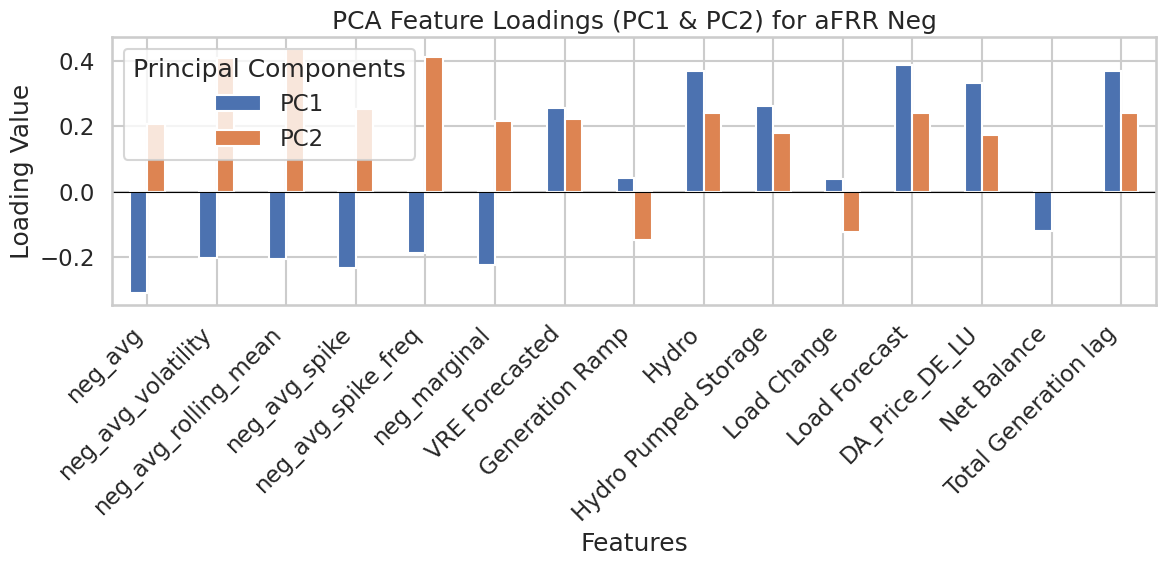

Explained variance ratio (POS): ['0.3262', '0.2170', '0.1206', '0.1084', '0.0757', '0.0400', '0.0308', '0.0215', '0.0198', '0.0143', '0.0092', '0.0070', '0.0048', '0.0036', '0.0011']

Feature loadings for PC1 & PC2:
                         PC1     PC2
Load Forecast         0.4099  0.1974
Total Generation lag  0.3970  0.1720
Hydro                 0.3934  0.2018
DA_Price_DE_LU        0.3156  0.2587
VRE Forecasted        0.3055  0.0663
pos_avg              -0.3015  0.2728
Hydro Pumped Storage  0.2625  0.2003
pos_avg_spike        -0.2069  0.3236
pos_marginal         -0.2037  0.2728
pos_avg_rolling_mean -0.1822  0.4160
pos_avg_spike_freq   -0.1444  0.4112
pos_avg_volatility   -0.1434  0.3920
Net Balance          -0.0846 -0.1677
Load Change           0.0213 -0.0231
Generation Ramp       0.0181 -0.0357


<Figure size 1200x600 with 0 Axes>

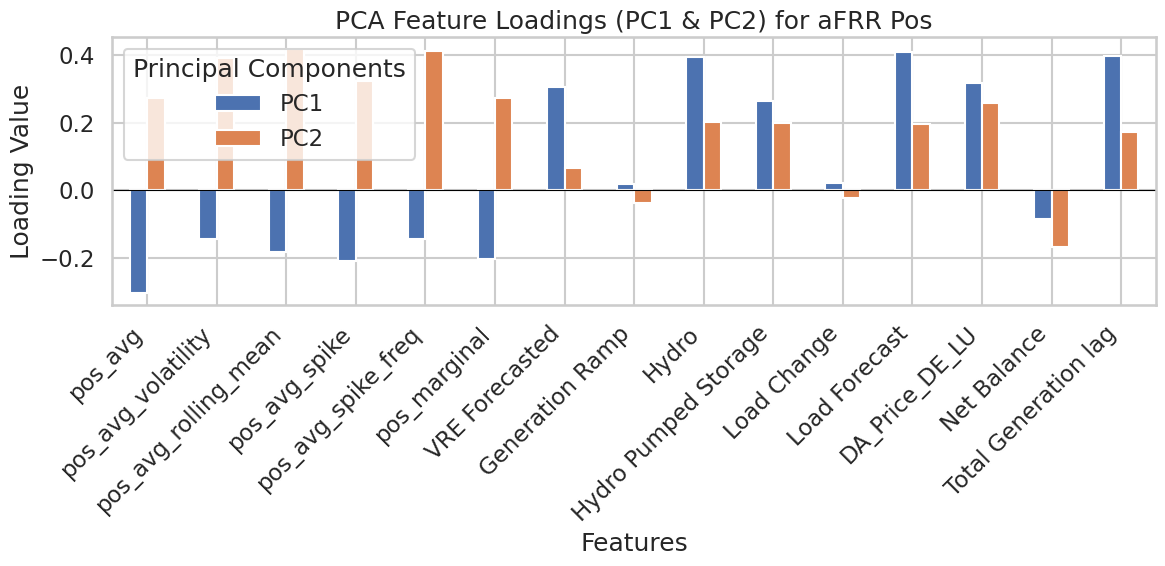

In [ ]:

# PCA on feature sets
pca_neg = PCA(n_components=len(compact_features_neg))
pca_neg.fit(X_neg_scaled_df)

pca_pos = PCA(n_components=len(compact_features_pos))
pca_pos.fit(X_pos_scaled_df)

# Get explained variance
explained_var_neg = pca_neg.explained_variance_ratio_
explained_var_pos = pca_pos.explained_variance_ratio_

# Get loadings (feature contributions to each PC)
loadings_neg = pd.DataFrame(
    pca_neg.components_.T,
    index=compact_features_neg,
    columns=[f'PC{i+1}' for i in range(len(compact_features_neg))]
)
loadings_pos = pd.DataFrame(
    pca_pos.components_.T,
    index=compact_features_pos,
    columns=[f'PC{i+1}' for i in range(len(compact_features_pos))]
)

print("Explained variance ratio (NEG):", [f"{x:.4f}" for x in explained_var_neg])
print("\nFeature loadings for PC1 & PC2:")
print(loadings_neg[['PC1', 'PC2']].sort_values(by='PC1', key=abs, ascending=False).to_string(float_format='%.4f'))

# Visualization: PC1 & PC2 loadings
plt.figure(figsize=(12, 6))
loadings_neg[['PC1', 'PC2']].plot(kind='bar', figsize=(12, 6))
plt.title("PCA Feature Loadings (PC1 & PC2) for aFRR Neg")
plt.ylabel("Loading Value")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend(title='Principal Components')
plt.tight_layout()
plt.show()

print("Explained variance ratio (POS):",[f"{x:.4f}" for x in explained_var_pos])
print("\nFeature loadings for PC1 & PC2:")
print(loadings_pos[['PC1', 'PC2']].sort_values(by='PC1', key=abs, ascending=False).to_string(float_format='%.4f'))

plt.figure(figsize=(12,6))
loadings_pos[['PC1', 'PC2']].plot(kind='bar', figsize=(12,6))
plt.title("PCA Feature Loadings (PC1 & PC2) for aFRR Pos")
plt.ylabel("Loading Value")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend(title='Principal Components')
plt.tight_layout()
plt.show()